# Simplified Tensorflow DRF Segmentation

In [1]:
!pip install simpletransformers
!pip install pandas
!pip install tensorflow
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import time
import logging
import torch

## Data Preprocessing

In [3]:
path = 'daily_weather_training_data_normalized.csv'

if(os.path.exists(path)):
  print('File Found:', path)
  df = pd.read_csv(path, usecols=['text', 'label'], low_memory=True, dtype=str, encoding='utf-8')
  df.head()

File Found: daily_weather_training_data_normalized.csv


<AxesSubplot:xlabel='label'>

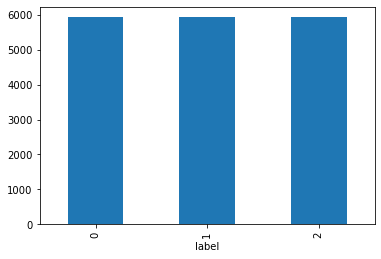

In [4]:
df['label'] = df['label'].astype(int)
df['text'] = df['text'].astype(str)

df['label'].value_counts()
df.groupby(['label']).size().plot.bar()

In [5]:
train,eval = train_test_split(df.astype(str),test_size=0.1)

In [6]:
train_df = pd.DataFrame({
    'text': train['text'],
    'labels': train['label']
})
train_df.columns = ["text", "labels"]
train_df.info()

df.sort_index()
eval_df = pd.DataFrame({
    'text': eval['text'].sort_index().truncate(before=800),
    'labels': eval['label'].sort_index().truncate(before=800)
})
eval_df.columns=["text", "labels"]

KeyError: 'labels'

## Model Loading and Training

In [ ]:
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs


# Logging for model
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_gpu = torch.cuda.is_available()
print('GPU Available:', train_gpu)
# Create a TransformerModel
model_args = ClassificationArgs(num_train_epochs=1,
                                reprocess_input_data=True,
                                overwrite_output_dir=True,
                                train_batch_size=1,
                                )

model = ClassificationModel('bert', 'nicoladecao/msmarco-word2vec256000-bert-base-uncased', num_labels=3, args=model_args, use_cuda=train_gpu) # Use the word2vec embeddings instead of the regular bert tokenizer
#model = ClassificationModel('bert', "bert-base-cased", num_labels=3, args=model_args, use_cuda=train_gpu)

In [ ]:
start = time.time()
model.train_model(train_df, eval_df=eval_df)
print('TRAINING TIME:', time.time()-start)
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

## Model Metrics

In [ ]:
print(result)
print(model_outputs)

lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = eval_df['labels'].tolist()
predicted = lst

In [ ]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
print(mat)

df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True)
plt.show()
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative'])
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

## Model Prediction

In [ ]:
def get_result(statement):
    result = model.predict([statement])
    print(result)
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'Negative',1:'Positive',2:'neutral'}
    print(sentiment_dict[pos])
    return sentiment_dict[pos]

sentiment = get_result(input("Input a phrase for Validation: "))
print("The input data was classified as:", sentiment)